In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
!unzip 122_260_bundle_archive.zip

Archive:  122_260_bundle_archive.zip
  inflating: household_power_consumption.txt  


In [25]:
df = pd.read_csv('/content/household_power_consumption.txt',sep=';',parse_dates={'date' : ['Date', 'Time']}, infer_datetime_format=True, 
                 na_values=['nan','?'], index_col='date')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [27]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [28]:
df = df.fillna(df.mean())

In [29]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

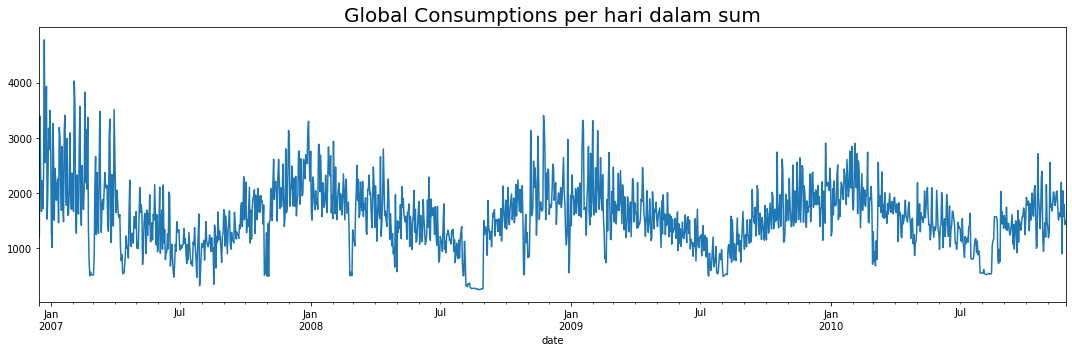

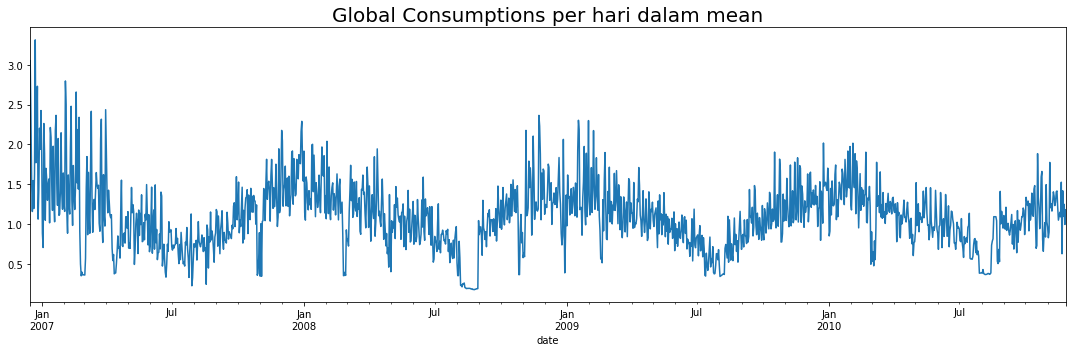

In [30]:
consume = df['Global_active_power'].resample('D') #resample per hari

plt.figure(figsize=(15,5))
consume.sum().plot()
plt.title('Global Consumptions per hari dalam sum',fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
consume.mean().plot()
plt.title('Global Consumptions per hari dalam mean',fontsize=20)
plt.tight_layout()
plt.show()


In [31]:
#menghapus kolom yang tidak ingin di prediksi
df = df

In [32]:
data_resample = df.resample('h').mean() #diresample berdasarkan jam
nilai = data_resample.values

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(0,1))
datascale = scaling.fit_transform(nilai)


In [34]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #konsep dari fungsi ini terinspirasi dari machine learning mastery, dengan sedikit edit dari saya
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [35]:
databersih = series_to_supervised(datascale, 1, 1)
databersih.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)',
       'var5(t)', 'var6(t)', 'var7(t)'],
      dtype='object')

In [36]:
#menghapus kolom yang tidak ingin diprediksi
#pada databersih.columns var1(t) adalah untuk Global Active Power, maka itu yang kita pertahankan sebagai yg ingin diprediksi,
#untuk var2(t) sampai var7(t) dihapus saja

databersih = databersih.drop(databersih.iloc[:,8:], axis=1)
print(databersih.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.636816   0.295738   0.337945  ...   0.011366   0.782418  0.545045
2   0.545045   0.103358   0.335501  ...   0.144652   0.782676  0.509006
3   0.509006   0.110073   0.283802  ...   0.030869   0.774169  0.488550
4   0.488550   0.096987   0.315987  ...   0.000000   0.778809  0.455597
5   0.455597   0.099010   0.434417  ...   0.008973   0.798917  0.322555

[5 rows x 8 columns]


In [41]:
split_time = 365*24*3 #3 tahun train
data_train = nilai[:split_time,:]
data_test = nilai[split_time:]

train_X, train_y = data_train[:, :-1], data_train[:, -1:]
test_X, test_y = data_test[:, :-1], data_test[:, -1:]



In [42]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 6) (26280, 1) (8309, 1, 6) (8309, 1)


In [43]:
model = tf.keras.Sequential([
                             tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(50),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(30, activation = 'relu'),
                             tf.keras.layers.Dense(10, activation = 'relu'),
                             tf.keras.layers.Dense(1)
])
num_epochs = 100
batch_size = 50

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = 'mae')

history = model.fit(train_X, train_y, epochs = num_epochs, batch_size = batch_size,
                        validation_data = (test_X, test_y), shuffle=False,
                        verbose = 2)

Epoch 1/100
526/526 - 4s - loss: 36.7014 - mae: 4.2489 - val_loss: 15.6233 - val_mae: 2.7237
Epoch 2/100
526/526 - 4s - loss: 19.1425 - mae: 2.9426 - val_loss: 16.6615 - val_mae: 2.8584
Epoch 3/100
526/526 - 4s - loss: 18.7040 - mae: 2.9059 - val_loss: 15.3861 - val_mae: 2.7012
Epoch 4/100
526/526 - 4s - loss: 18.5915 - mae: 2.8770 - val_loss: 15.3650 - val_mae: 2.7136
Epoch 5/100
526/526 - 3s - loss: 18.5406 - mae: 2.8766 - val_loss: 15.2944 - val_mae: 2.7020
Epoch 6/100
526/526 - 3s - loss: 18.4428 - mae: 2.8541 - val_loss: 15.4238 - val_mae: 2.7241
Epoch 7/100
526/526 - 3s - loss: 18.3118 - mae: 2.8286 - val_loss: 15.7121 - val_mae: 2.7631
Epoch 8/100
526/526 - 3s - loss: 18.0750 - mae: 2.8142 - val_loss: 15.1544 - val_mae: 2.6979
Epoch 9/100
526/526 - 3s - loss: 18.0455 - mae: 2.8016 - val_loss: 15.0317 - val_mae: 2.6485
Epoch 10/100
526/526 - 3s - loss: 17.9804 - mae: 2.7911 - val_loss: 15.4080 - val_mae: 2.7109
Epoch 11/100
526/526 - 4s - loss: 17.8602 - mae: 2.7748 - val_loss: 1

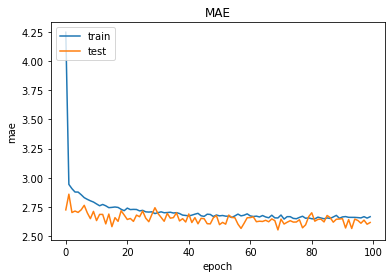

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()